In [23]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/5-gamers/gamer5-annotations.csv
/kaggle/input/5-gamers/gamer2-ppg-2000-01-01.csv
/kaggle/input/5-gamers/gamer2-annotations.csv
/kaggle/input/5-gamers/gamer1-annotations.csv
/kaggle/input/5-gamers/gamer4-ppg-2000-01-01.csv
/kaggle/input/5-gamers/gamer1-ppg-2000-01-02.csv
/kaggle/input/5-gamers/gamer5-ppg-2000-01-01.csv
/kaggle/input/5-gamers/gamer4-annotations.csv
/kaggle/input/5-gamers/gamer2-ppg-2000-01-02.csv
/kaggle/input/5-gamers/gamer3-ppg-2000-01-02.csv
/kaggle/input/5-gamers/gamer1-ppg-2000-01-01.csv
/kaggle/input/5-gamers/gamer5-ppg-2000-01-02.csv
/kaggle/input/5-gamers/gamer4-ppg-2000-01-02.csv
/kaggle/input/5-gamers/gamer3-ppg-2000-01-01.csv
/kaggle/input/5-gamers/gamer3-annotations.csv


In [24]:
!pip install heartpy

In [25]:
!pip install scikit-learn==1.4.2

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, lfilter_zi
import math
from sklearn.neighbors import KNeighborsClassifier
import heartpy as hp
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [27]:
annotations_train = ['gamer1-annotations.csv', 'gamer2-annotations.csv', 'gamer3-annotations.csv', 'gamer4-annotations.csv']
ppg_train = ['gamer1-ppg-2000-01-01.csv', 'gamer1-ppg-2000-01-02.csv','gamer2-ppg-2000-01-01.csv', 'gamer2-ppg-2000-01-02.csv','gamer3-ppg-2000-01-01.csv', 'gamer3-ppg-2000-01-02.csv', 'gamer4-ppg-2000-01-01.csv', 'gamer4-ppg-2000-01-02.csv']

In [28]:
# returns dataframe of ppg signal based on filename (file from kaggle input folder)
# removes non-finite values
# moving average filter
 
def read_ppg(filename):
    df = pd.read_csv('/kaggle/input/5-gamers/' + filename)
    df = df.groupby('Time')['Red_Signal'].mean().reset_index()
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df['Red_Signal'] = df['Red_Signal'].fillna(value=df['Red_Signal'].mean())
    df.astype({'Red_Signal': 'int64'}).dtypes
    df.Red_Signal.rolling(50, min_periods=1).mean() # moving average
    return df["Red_Signal"]

In [29]:
df2 = pd.read_csv('/kaggle/input/5-gamers/gamer4-ppg-2000-01-02.csv')
df2.describe()

,Red_Signal
count,3.733929e+06
mean,4.080905e+02
std,8.161586e+01
min,0.000000e+00
25%,3.700000e+02
50%,4.100000e+02
75%,4.490000e+02
max,7.590000e+02


In [30]:
def annotated_resampled(file):
    df = pd.read_csv('/kaggle/input/5-gamers/'+file)
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df.set_index('Datetime', inplace=True)
    df = df[df['Event'] == 'Stanford Sleepiness Self-Assessment (1-7)']
    df.drop(columns = ['Event'], inplace = True)
    
    df['Value'] = df['Value'].astype(int)
#     df_resampled = df.resample('10L').mean().interpolate(method='linear')
    df_resampled = df.resample('500L').mean().interpolate(method='linear')
    df_resampled = df_resampled.resample('100L').mean().interpolate(method='linear')
    df_resampled = df_resampled.resample('10L').mean().interpolate(method='linear')

    # Add noise to the resampled data
    noise_mean = 0
    noise_std = 0.3  # You can adjust the standard deviation to control the magnitude of noise

    # Generate random noise
    noise = np.random.normal(noise_mean, noise_std, df_resampled.shape)

    # Add noise to the resampled DataFrame
    df_with_noise = df_resampled + noise

    # Clip the values to ensure they remain within a specific range, e.g., [0, 7] for the Stanford Sleepiness Scale
    df_with_noise = df_with_noise.clip(1, 7)


    return df_with_noise


In [31]:
df_annotation = annotated_resampled(annotations_train[0])
print(len(df_annotation))
df_annotation.head()

/tmp/ipykernel_34/662668424.py:10: FutureWarning: 'L' is deprecated and will be removed in a future version, please use 'ms' instead.
  df_resampled = df.resample('500L').mean().interpolate(method='linear')
/tmp/ipykernel_34/662668424.py:11: FutureWarning: 'L' is deprecated and will be removed in a future version, please use 'ms' instead.
  df_resampled = df_resampled.resample('100L').mean().interpolate(method='linear')
/tmp/ipykernel_34/662668424.py:12: FutureWarning: 'L' is deprecated and will be removed in a future version, please use 'ms' instead.
  df_resampled = df_resampled.resample('10L').mean().interpolate(method='linear')


8640001


,Value
Datetime,
2000-01-01 11:00:00.000,2.977925
2000-01-01 11:00:00.010,3.093926
2000-01-01 11:00:00.020,3.198745
2000-01-01 11:00:00.030,2.456415
2000-01-01 11:00:00.040,2.774530


In [32]:
def get_resampled_data(file1, file2):
    # Read the first file
    df1 = pd.read_csv('/kaggle/input/5-gamers/' + file1)
    df1['Time'] = pd.to_datetime(file1[11:-4] + ' ' + df1['Time'])
    df1 = df1.groupby('Time')['Red_Signal'].mean().reset_index()
    df1.set_index('Time', inplace=True)
    df1_resampled = df1.resample('10L').mean(numeric_only=True).interpolate(method='linear')
    
    # Read the second file
    df2 = pd.read_csv('/kaggle/input/5-gamers/' + file2)
    df2['Time'] = pd.to_datetime(file2[11:-4] + ' ' + df2['Time'])
    df2 = df2.groupby('Time')['Red_Signal'].mean().reset_index()
    df2.set_index('Time', inplace=True)
    df2_resampled = df2.resample('10L').mean(numeric_only=True).interpolate(method='linear')
    
    # Concatenate the resampled DataFrames
    combined_df = pd.concat([df1_resampled, df2_resampled])
    combined_df.reset_index(inplace=True)
    combined_df.set_index('Time', inplace=True)
    
    return combined_df

In [33]:
df = get_resampled_data(ppg_train[0], ppg_train[1])
print(len(df))
df.head()

/tmp/ipykernel_34/1306454166.py:7: FutureWarning: 'L' is deprecated and will be removed in a future version, please use 'ms' instead.
  df1_resampled = df1.resample('10L').mean(numeric_only=True).interpolate(method='linear')
/tmp/ipykernel_34/1306454166.py:14: FutureWarning: 'L' is deprecated and will be removed in a future version, please use 'ms' instead.
  df2_resampled = df2.resample('10L').mean(numeric_only=True).interpolate(method='linear')


7967362


,Red_Signal
Time,
2000-01-01 12:54:40.360,601.750000
2000-01-01 12:54:40.370,65.083333
2000-01-01 12:54:40.380,0.000000
2000-01-01 12:54:40.390,0.000000
2000-01-01 12:54:40.400,0.000000


In [34]:
df.describe()

,Red_Signal
count,7.967362e+06
mean,4.600928e+02
std,1.020248e+02
min,0.000000e+00
25%,4.285000e+02
50%,4.685000e+02
75%,5.042500e+02
max,7.660000e+02


In [35]:
# df.head(20)

In [36]:
# df.describe()

In [37]:
combined_df = df.join(df_annotation)
combined_df.dropna(inplace= True)
combined_df.head()

,Red_Signal,Value
Time,,
2000-01-01 12:54:40.360,601.750000,1.523310
2000-01-01 12:54:40.370,65.083333,1.731121
2000-01-01 12:54:40.380,0.000000,2.021834
2000-01-01 12:54:40.390,0.000000,1.779273
2000-01-01 12:54:40.400,0.000000,1.629997


In [38]:
print(len(df), len(df_annotation), len(combined_df))

7967362 8640001 7920567


In [39]:
def process_ppg(data):
    sr = 100 # Sampling rate of 1 sample per second
    filtered = hp.filter_signal(data, [0.5, 15], sample_rate=sr, order=3, filtertype='bandpass')
    
    # Segment parameters for 8 seconds of data
    segment_width = 8
    segment_overlap = 0  # No overlap between segments
    segment_min_size = 8  # Ensure each segment is at least 8 seconds
    
    # Process the data segment-wise
    working_data, measures = hp.process_segmentwise(filtered, sample_rate=sr, segment_width=segment_width,
                                                     segment_overlap=segment_overlap, segment_min_size=segment_min_size)
    
    return working_data, measures


In [40]:
w, m = process_ppg(combined_df['Red_Signal'])
m.keys()

/opt/conda/lib/python3.10/site-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/opt/conda/lib/python3.10/site-packages/numpy/ma/core.py:5334: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: 

dict_keys(['bpm', 'ibi', 'sdnn', 'sdsd', 'rmssd', 'pnn20', 'pnn50', 'hr_mad', 'sd1', 'sd2', 's', 'sd1/sd2', 'breathingrate', 'segment_indices'])

In [22]:
m['bpm']

NameError: name 'm' is not defined

In [52]:
# returns dataframe of selected features from the heartpy processing result removing NaN values 

def pick_features(all_measures, selected):
    x_train = []
    for i in range(len(all_measures['bpm'])):
        row = []
        for cat in selected:
            value = all_measures[cat][i]
            row.append(remove_nan(value))
        x_train.append(row)
    return x_train
   

In [53]:
import math

def remove_nan(val):
    if math.isnan(val):
        return 0

    return val

In [54]:
 def x_data(m, selected_features):
    return pick_features(m, selected_features)

In [55]:
combined_df.head()

,Red_Signal,Value
Time,,
2000-01-01 12:54:40.360,601.750000,2.066202
2000-01-01 12:54:40.370,65.083333,1.958523
2000-01-01 12:54:40.380,0.000000,1.898916
2000-01-01 12:54:40.390,0.000000,2.447087
2000-01-01 12:54:40.400,0.000000,2.314013


In [56]:
features = ['bpm', 'ibi', 'breathingrate']
X = x_data(m, features)
len(X)

9685

In [57]:
df_unsample = df_annotation.resample('8S').mean().interpolate(method='linear')
df_unsample.head()

/tmp/ipykernel_33/2423581081.py:1: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df_unsample = df_annotation.resample('8S').mean().interpolate(method='linear')


,Value
Datetime,
2000-01-01 11:00:00,3.004114
2000-01-01 11:00:08,2.984380
2000-01-01 11:00:16,2.986087
2000-01-01 11:00:24,2.992911
2000-01-01 11:00:32,3.000748


In [58]:
df_unsample['float_column'] = df_unsample['Value'].round()
Y = df_unsample['float_column'][:len(X)]
Y

Datetime
2000-01-01 11:00:00    3.0
2000-01-01 11:00:08    3.0
2000-01-01 11:00:16    3.0
2000-01-01 11:00:24    3.0
2000-01-01 11:00:32    3.0
                      ... 
2000-01-02 08:30:40    5.0
2000-01-02 08:30:48    5.0
2000-01-02 08:30:56    5.0
2000-01-02 08:31:04    5.0
2000-01-02 08:31:12    5.0
Freq: 8s, Name: float_column, Length: 9685, dtype: float64

In [ ]:
# import random

# test_arr = []
# for i in range(1, 801):
#     rval = random.randint(500, 1000)
#     test_arr.append(rval)
    
# len(test_arr)

# w, m = process_ppg(test_arr)
# m.keys()
# m['bpm']

In [ ]:
# def read_gamer(x_file1, x_file2, y_file, features):
#     x_result = x_data(x_file1, features)
#     x_result = np.concatenate((x_result, x_data(x_file2, features)), axis=0)
#     y_result = y_data(y_file, len(x_result))
#     return x_result, y_result

# Reading data

In [ ]:
# features = ['bpm', 'ibi', 'breathingrate']

**Training data**

In [ ]:
# x_train = []
# y_train = []

# for i in range(4):
#     x, y = read_gamer(ppg_train[i*2], ppg_train[i*2+1], annotations_train[i], features)
        
#     for line in x:
#         x_train.append(line)
#     y_train = y_train + y

In [62]:
# Oversample imbalanced dataset with SMOTE
counter_original = Counter(Y)
print(counter_original)


# oversampling the dataset

strat = {1:1794, 2:4961, 3:1914, 4:6000, 5:6000}

oversample = SMOTE(sampling_strategy = strat)
x_over, y_over = oversample.fit_resample(X, Y)
X_u, Y_u = x_over, y_over


# undersampling (gave worse results)

#undersample = RandomUnderSampler(sampling_strategy=0.5)
#x_under, y_under = undersample.fit_resample(x_train, y_train)
#x_train, y_train = x_under, y_under

counter = Counter(Y_u)
print(counter)

Counter({2.0: 4956, 3.0: 1914, 1.0: 1792, 5.0: 796, 4.0: 227})
Counter({4.0: 6000, 5.0: 6000, 2.0: 4961, 3.0: 1914, 1.0: 1794})


**Test data**

In [63]:
# x_test, y_test = read_gamer('gamer5-ppg-2000-01-01.csv', 'gamer5-ppg-2000-01-02.csv', 'gamer5-annotations.csv', features)

**Visualisation**

In [64]:
len(X[0])

3

<Figure size 1500x500 with 0 Axes>

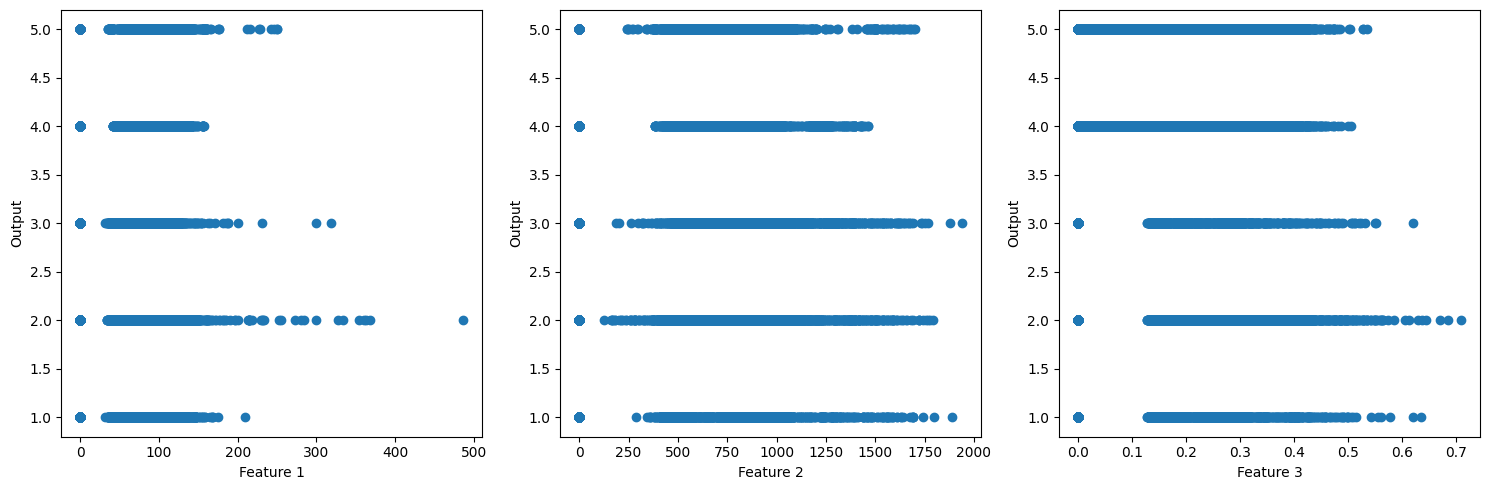

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Unpacking X into separate lists for each feature
feature1 = [x[0] for x in X_u]
feature2 = [x[1] for x in X_u]
feature3 = [x[2] for x in X_u]

# Plotting each feature against the output
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(feature1, Y_u)
plt.xlabel('Feature 1')
plt.ylabel('Output')

plt.subplot(1, 3, 2)
plt.scatter(feature2, Y_u)
plt.xlabel('Feature 2')
plt.ylabel('Output')

plt.subplot(1, 3, 3)
plt.scatter(feature3, Y_u)
plt.xlabel('Feature 3')
plt.ylabel('Output')

plt.tight_layout()
plt.show()

In [66]:
# plt.figure(1)
# fig = plt.figure(figsize = (3, 4))
# plt.bar(['Alert', 'Too tired'], counter_original.values(), width=0.5)
# plt.title("Before")

# plt.figure(2)
# fig = plt.figure(figsize = (3, 4))
# plt.bar(['Alert', 'Too tired'], counter.values(), width=0.5)
# plt.title("After SMOTE")

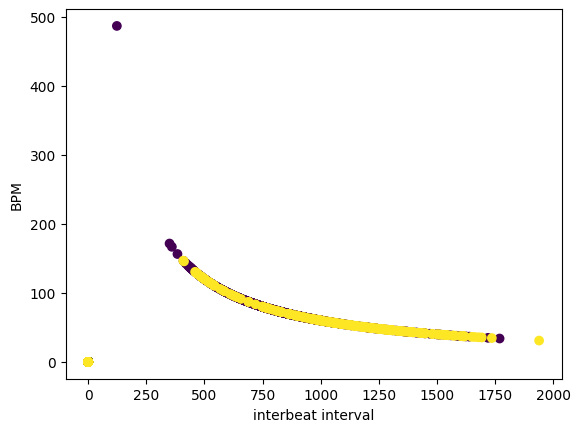

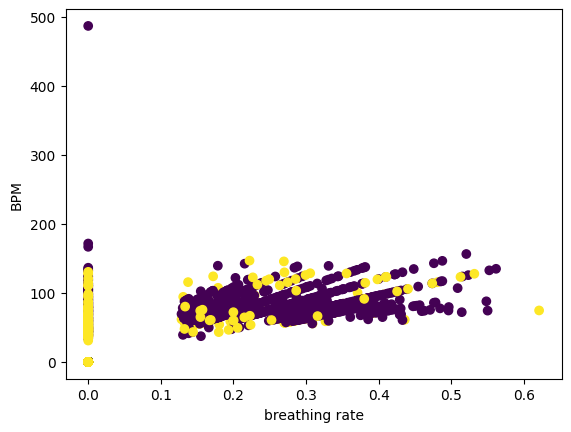

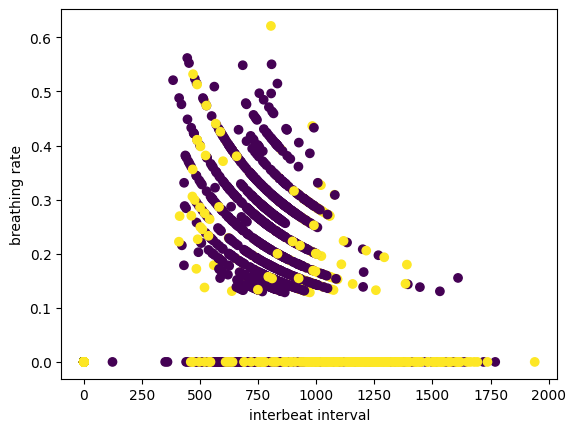

In [67]:
bpm = []
ibi = []
breath = []

for row in X[:2000]:
    bpm.append(row[0])
    ibi.append(row[1])
    breath.append(row[2])
 
plt.figure(1)
plt.scatter(ibi, bpm, c=Y[:2000])
plt.xlabel('interbeat interval')
plt.ylabel('BPM')

plt.figure(2)
plt.scatter(breath, bpm, c=Y[:2000])
plt.xlabel('breathing rate')
plt.ylabel('BPM')

plt.figure(3)
plt.scatter(ibi, breath, c=Y[:2000])
plt.xlabel('interbeat interval')
plt.ylabel('breathing rate')

plt.show()

In [68]:
# # Moving average
# df_ppg1_1 = pd.read_csv('/kaggle/input/5-gamers/gamer1-ppg-2000-01-01.csv', encoding='utf-8')
# clean1_1 = df_ppg1_1.copy()
# clean1_1['Red_Signal'] = df_ppg1_1.Red_Signal.rolling(30, min_periods=1).mean()

# df_ppg1_1.iloc[200:2000].plot()
# clean1_1.iloc[200:2000].plot()

In [69]:
# hrdata = hp.get_data('/kaggle/input/5-gamers/gamer1-ppg-2000-01-01.csv', column_name='Red_Signal')
# working_data, measures = hp.process(hrdata, sample_rate=100)
# hp.plotter(working_data, measures, title='Heart Beat Detection on Noisy Signal', figsize=(12,4))

# #zoomed in
# hp.plotter(working_data, measures, figsize=(12,4))
# plt.xlim(230, 250)

# Classification algorithms

In [70]:
algorithms = ['Decision tree', 'Random forest', 'KNN', 'Gaussian Naive Bayes', 'Multinomial Naive Bayes']

In [ ]:
from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_u, Y_u, test_size=0.2, random_state=42, stratify = Y_u)

In [ ]:
len(x_train)

In [ ]:
# regressor = LinearRegression()

# # Fit the model on the training data
# regressor.fit(X_train, Y_train)

# # Predict on the testing data
# Y_pred = regressor.predict(X_test)

# # Calculate errors
# mse = mean_squared_error(Y_test, Y_pred)
# mae = mean_absolute_error(Y_test, Y_pred)
# r2 = r2_score(Y_test, Y_pred)

# print("Mean Squared Error:", mse)
# print("Mean Absolute Error:", mae)
# print("R^2 Score:", r2)

In [89]:
!pip install scikit-learn==1.4.2

In [90]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.naive_bayes import MultinomialNB

In [ ]:
len()

In [78]:
dt = DecisionTreeClassifier(criterion='gini', max_depth = 15, random_state=8).fit(x_train, y_train)

In [79]:
rf = RandomForestClassifier(n_estimators=150, max_depth=15, random_state=0).fit(x_train, y_train)

In [80]:
knn = KNeighborsClassifier(n_neighbors=20).fit(x_train, y_train)

In [ ]:
# gnb = GaussianNB().fit(x_train, y_train)

In [ ]:
# mnb = MultinomialNB().fit(x_train, y_train)

In [81]:
models = [dt, rf, knn]

In [85]:
accuracy_df = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1-score'])
results = []


for i in range(len(models)):
    prediction = models[i].predict(x_test)
    
    print(algorithms[i], "confusion matrix")
    print(confusion_matrix(y_test, prediction))
    
    recall = recall_score(y_test, prediction, average = 'micro')
    precision = precision_score(y_test, prediction, average = 'micro')
    acc = accuracy_score(y_test, prediction)
    f1 = f1_score(y_test, prediction, average = 'micro')
    
    print(recall, precision, acc, f1)
#     accuracy_df = accuracy_df.append({'model': algorithms[i], 'accuracy': acc, 'precision' : precision, 'recall' : recall, 'f1-score' : f1}, ignore_index=True)

# print(accuracy_df)

Decision tree confusion matrix
[[ 37 133  33  74  82]
 [ 73 424  77 168 250]
 [ 23 147  46 119  48]
 [ 13 120  18 894 155]
 [ 14 175  20 125 866]]
0.5483792936623125 0.5483792936623125 0.5483792936623125 0.5483792936623125
Random forest confusion matrix
[[ 39 141  24  76  79]
 [ 56 438  70 175 253]
 [ 21 144  44 123  51]
 [  4  61  16 962 157]
 [  9 103  14 112 962]]
0.5914368650217707 0.5914368650217707 0.5914368650217707 0.5914368650217707
KNN confusion matrix
[[ 17 100  11 128 103]
 [ 20 320  36 289 327]
 [  9 104  19 162  89]
 [  7 142  16 816 219]
 [  9 193   7 205 786]]
0.47363328495403967 0.47363328495403967 0.47363328495403967 0.47363328495403967


In [96]:
!pip uninstall joblib -y

Found existing installation: joblib 1.4.0
Uninstalling joblib-1.4.0:
  Successfully uninstalled joblib-1.4.0


In [97]:
!pip install joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.2/301.2 kB 6.1 MB/s eta 0:00:00:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.


In [98]:
!pip install scikit-learn

In [102]:
from joblib import dump, load
dump(rf, 'heart_rate_latest.joblib')

['heart_rate_latest.joblib']

In [103]:
abc = load('heart_rate_latest.joblib')

In [104]:
abc

RandomForestClassifier(max_depth=15, n_estimators=150, random_state=0)

In [106]:
!pip show scikit-learn

Name: scikit-learn
Version: 1.4.2
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /opt/conda/lib/python3.10/site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: bayesian-optimization, Boruta, category-encoders, cesium, eli5, esda, fastai, gplearn, hep-ml, hmmlearn, hpsklearn, hypertools, imbalanced-learn, kmapper, kmodes, librosa, lime, mapclassify, mlxtend, nilearn, pyLDAvis, pynndescent, qudida, rgf-python, scattertext, scikit-learn-intelex, scikit-optimize, scikit-plot, segregation, shap, sklearn-pandas, spopt, spreg, TPOT, tsfresh, umap-learn, vecstack, woodwork, yellowbrick


In [88]:
rf.predict([[1,2,3]])

array([2.])